### Initialization

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sys
from scipy.stats import multivariate_normal

# Add the parent directory of simpleparameterisation to the sys.path list
sys.path.append('../')

# Now you can import simpleparameterisation from the new location
import TPCevt as TPC

det = TPC.Detector("Simple TPC with Atmospheric Ar (default values)")


In [2]:
# Initial Parameter
pitch_x = 0.1
pitch_y = 0.1
pitch_z = 0.1
std = det.PSFstd = 1
thresh = 1e-20
chart_scaling = 200

In [3]:
def ReadoutGain(DriftedEvt):
    DriftedEvtGrid = np.stack(DriftedEvt, axis=-1)
    minvals = np.array([DriftedEvtGrid[0].min(), DriftedEvtGrid[1].min(), DriftedEvtGrid[2].min()])
    maxvals = np.array([DriftedEvtGrid[0].max(), DriftedEvtGrid[1].max(), DriftedEvtGrid[2].max()])

    ReadoutGrid = np.mgrid[np.floor(minvals[0]):np.ceil(maxvals[0]):pitch_x,
                        np.floor(minvals[1]):np.ceil(maxvals[1]):pitch_y,
                        np.floor(minvals[2]):np.ceil(maxvals[2]):pitch_z,
                        ]

    pos = np.stack(ReadoutGrid, axis=-1)
    ReadoutEvt = None
    for i in range(len(DriftedEvt)):
        # thisGain = np.random.exponential(scale=det.gain_mean)
        thisGain = 1
        rv = multivariate_normal([DriftedEvt[i][0], DriftedEvt[i][1], DriftedEvt[i][2]], np.diag([det.PSFstd, det.PSFstd, det.PSFstd]))
        if ReadoutEvt is None:
            ReadoutEvt = rv.pdf(pos)*pitch_x*pitch_y*pitch_z*thisGain
        else:
            ReadoutEvt += rv.pdf(pos)*pitch_x*pitch_y*pitch_z*thisGain
    themask = ReadoutEvt >= thresh
    return pd.DataFrame({'x': ReadoutGrid[0][themask].flatten(),
                                    'y':ReadoutGrid[1][themask].flatten(),
                                    'z':ReadoutGrid[2][themask].flatten(),
                                    'Nel': ReadoutEvt[themask]
                                    })


def generate_random_coordinates(N):
    # Generate random [x, y, z] coordinates
    x = np.random.rand(N)
    y = np.random.rand(N)
    z = np.random.rand(N)

    # Combine x, y, z coordinates into a single array
    coordinates = np.column_stack((x, y, z))

    return coordinates

def plotReadout(ReadoutEvt, a, b):
    plt.figure(1)
    projectxy = pd.DataFrame(ReadoutEvt.groupby(['x','y'])['Nel'].sum()).reset_index()
    plt.scatter(projectxy.x,projectxy.y, c=projectxy.Nel, s=((projectxy.Nel/np.max(projectxy.Nel))**0.5)*chart_scaling)
    plt.colorbar()
    plt.xlim(a, b)
    plt.ylim(a, b)
    plt.title(" X-Y Chart ")

    plt.figure(2)
    projectxdt = pd.DataFrame(ReadoutEvt.groupby(['x','z'])['Nel'].sum()).reset_index()
    plt.scatter(projectxdt.x,projectxdt.z, c=projectxdt.Nel, s=((projectxdt.Nel/np.max(projectxdt.Nel))**0.5)*chart_scaling)
    plt.colorbar()
    plt.xlim(a, b)
    plt.ylim(a, b)
    plt.title(" X-Z Chart ")

    plt.figure(3)
    projectydt = pd.DataFrame(ReadoutEvt.groupby(['y','z'])['Nel'].sum()).reset_index()
    plt.scatter(projectydt.y,projectydt.z, c=projectydt.Nel, s=((projectydt.Nel/np.max(projectydt.Nel))**0.5)*chart_scaling)
    plt.colorbar()
    plt.xlim(a, b)
    plt.ylim(a, b)
    plt.title(" Y-Z Chart ")
    
    fig = plt.figure(4)
    ax = fig.add_subplot(111, projection='3d')
    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    ax.set_zlabel('Z axis')
    scatter = ax.scatter(ReadoutEvt['x'], ReadoutEvt['y'], ReadoutEvt['z'], c=ReadoutEvt['Nel'], cmap='viridis', marker='o')
    cbar = plt.colorbar(scatter)
    plt.title(" X-Y-Z Chart")
    plt.show()

### Benchmark 1

In [4]:
pitch_x = 1
pitch_y = 1
pitch_z = 1
std = det.PSFstd = 1
thresh = 1e-20

DriftedEvt = np.array([[1,1,1], [5,5,5], [10,10,10]])
ReadoutEvt = ReadoutGain(DriftedEvt)

In [5]:
print(ReadoutEvt)

       x    y    z           Nel
0    1.0  1.0  1.0  6.349364e-02
1    1.0  1.0  2.0  3.851084e-02
2    1.0  1.0  3.0  8.592930e-03
3    1.0  1.0  4.0  7.053549e-04
4    1.0  1.0  5.0  2.130689e-05
..   ...  ...  ...           ...
724  9.0  9.0  5.0  9.419244e-08
725  9.0  9.0  6.0  7.840071e-06
726  9.0  9.0  7.0  2.594849e-04
727  9.0  9.0  8.0  3.161162e-03
728  9.0  9.0  9.0  1.416735e-02

[729 rows x 4 columns]


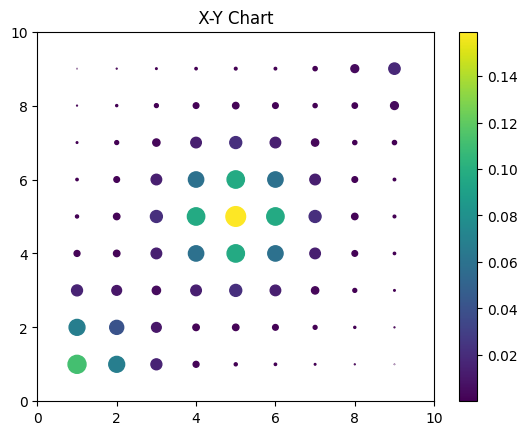

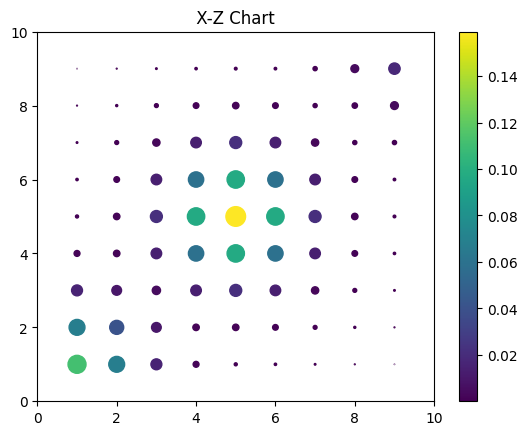

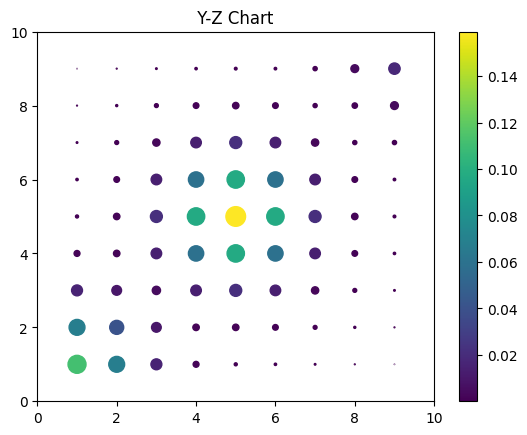

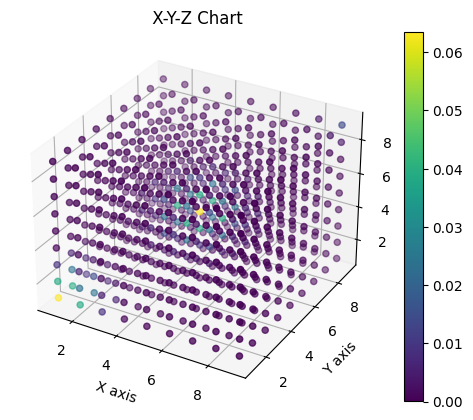

In [7]:
plotReadout(ReadoutEvt, 0, 10)

### Benchmark 2

In [ ]:
pitch_x = 1
pitch_y = 1
pitch_z = 1
std = det.PSFstd = 1
thresh = 1e-20

DriftedEvt = np.array([[1,1,1], [5000, 5000, 5000], [10000, 10000, 10000]])
ReadoutEvt = ReadoutGain(DriftedEvt)

MemoryError: Unable to allocate 21.8 TiB for an array with shape (3, 9999, 9999, 9999) and data type float64

### Benchmark 3

In [9]:

N = 100  # Replace 10 with the desired length
k = 100

np.random.seed(10)
DriftedEvt = generate_random_coordinates(N)*k
print(DriftedEvt)


[[77.13206433 57.81364299 81.33160837]
 [ 2.07519494 85.39337505 78.48667183]
 [63.36482349  6.80972735 39.34191124]
 [74.88038825 46.45308078 86.44791938]
 [49.85070123 78.19491186 38.40307681]
 [22.47966455 71.86028104 25.73028872]
 [19.80628648 58.60219801 82.94019198]
 [76.05307122  3.70944132 73.63827038]
 [16.91108366 35.06563913 50.76009081]
 [ 8.83398142 56.31906845 64.4326615 ]
 [68.53598184 29.97298724 21.31865654]
 [95.33933462 51.23341533 89.57089487]
 [ 0.39482663 67.34669253 96.59462515]
 [51.21922634 15.91937334 31.70015623]
 [81.26209617  5.04776702 86.55526182]
 [61.25260668 33.78158871 31.02837069]
 [72.17553174 10.80637728  2.52639454]
 [29.18760682 17.89028086  4.91951578]
 [91.77741225 88.58270962 18.4626838 ]
 [71.45757834 36.53649712  6.90333416]
 [54.2544368  21.87693492 25.74754234]
 [14.21700476 75.24961702 91.35817316]
 [37.33407601 10.68795844 45.7849512 ]
 [67.41336151 74.46032408 13.02117895]
 [44.18331744 46.97852934 80.98916654]
 [43.40139933 59.82556713

In [ ]:
pitch_x = 1
pitch_y = 1
pitch_z = 1
std = det.PSFstd = 1
thresh = 1e-20

ReadoutEvt = ReadoutGain(DriftedEvt)

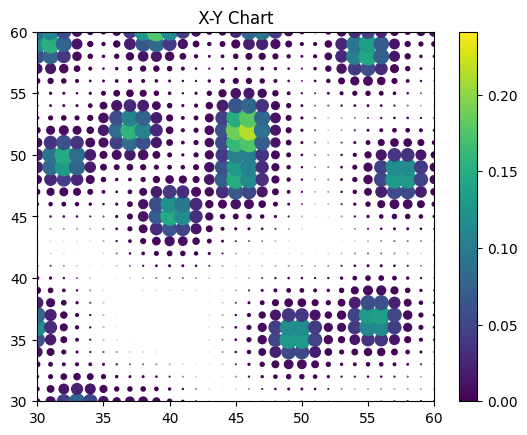

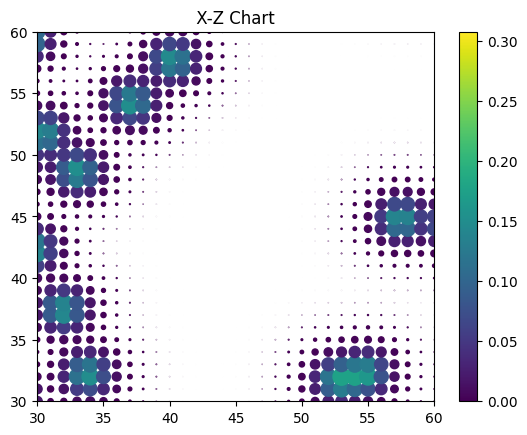

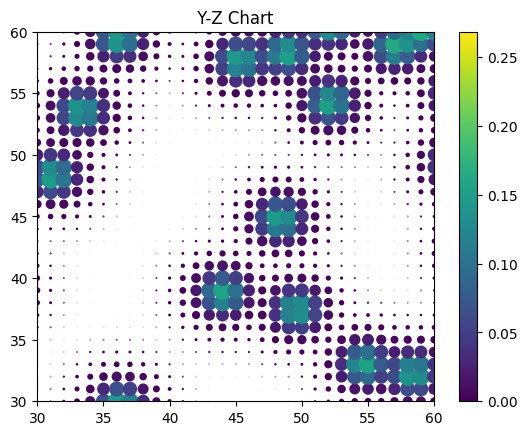

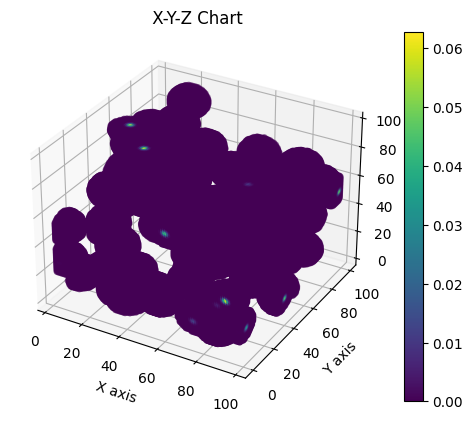

In [ ]:
plotReadout(ReadoutEvt, 30, 60)